# Main Objective

Lorem ipsum.

# Setup environment

In [1]:
%%capture
!pip install --upgrade tensorflow

In [2]:
%%capture --no-display
import os
import glob
import random
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import image as img
from tqdm import tqdm

2024-09-04 22:29:39.813188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 22:29:39.826120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 22:29:39.829910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 22:29:39.838940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 22:29:40.518410: W tensorflow/compiler/tf2

In [3]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [4]:
# Impose a seed for reproducibility
random_seed = 421
random.seed(random_seed)

# Dataset

## Dataset description

Lorem ipsum.

## Credits for the dataset

> Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.

> Bird, J.J. and Lotfi, A. (2024). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images.

## Link to download the dataset

[https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [5]:
# Set the local path
path_dataset = '/media/guillaume/DATA/COMPUTER_VISION_DATASETS/CIFAKE'

In [6]:
# Derive the train/test and real/fake paths
path_dataset_train = os.path.join(path_dataset, 'train')
path_dataset_train_real = os.path.join(path_dataset_train, 'REAL')
path_dataset_train_fake = os.path.join(path_dataset_train, 'FAKE')
path_dataset_test = os.path.join(path_dataset, 'test')
path_dataset_test_real = os.path.join(path_dataset_test, 'REAL')
path_dataset_test_fake = os.path.join(path_dataset_test, 'FAKE')

In [7]:
# List the samples
samples_list_train_real = list(glob.glob(os.path.join(path_dataset_train_real, '*.jpg')))
samples_list_test_real = glob.glob(os.path.join(path_dataset_test_real, '*.jpg'))
samples_list_train_fake = glob.glob(os.path.join(path_dataset_train_fake, '*.jpg'))
samples_list_test_fake = glob.glob(os.path.join(path_dataset_test_fake, '*.jpg'))

In [8]:
# Count the number of samples and ensure the distribution is balanced
print('Number of samples:')
print('Train split \t Real images: \t {}'.format(len(samples_list_train_real)))
print('Test split \t Real images: \t {}'.format(len(samples_list_test_real)))
print('Train split \t Fake images: \t {}'.format(len(samples_list_train_fake)))
print('Test split \t Fake images: \t {}'.format(len(samples_list_test_fake)))

Number of samples:
Train split 	 Real images: 	 50000
Test split 	 Real images: 	 10000
Train split 	 Fake images: 	 50000
Test split 	 Fake images: 	 10000


In [9]:
# Apply in-place random shuffling
random.shuffle(samples_list_train_real)
random.shuffle(samples_list_test_real)
random.shuffle(samples_list_train_fake)
random.shuffle(samples_list_test_fake)

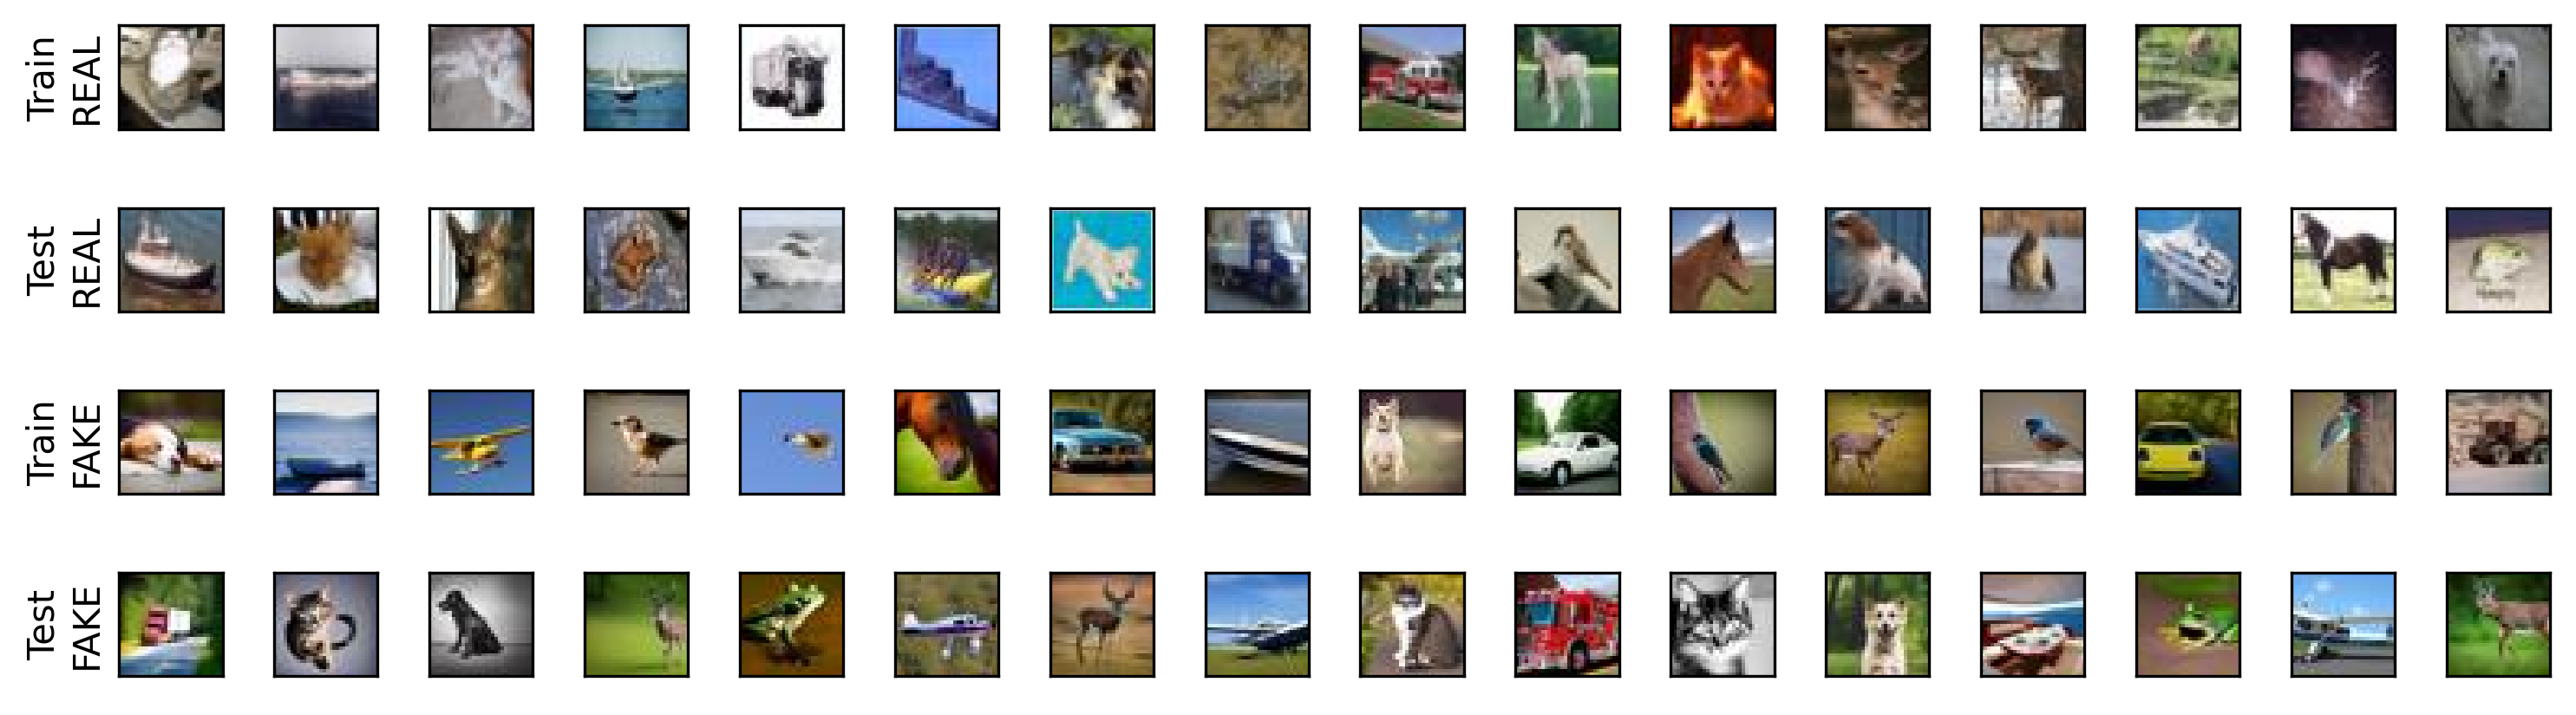

In [38]:
# Display a few images
number_of_displayed_samples = 16

fig, ax = plt.subplots(4, number_of_displayed_samples)
fig.set_dpi(300)
fig.set_size_inches(10, 3, forward=True)

for index in range(number_of_displayed_samples):

    axx = ax[0, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
    plt.ylabel('Train\nREAL') if index==0 else None

    axx = ax[1, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
    plt.ylabel('Test\nREAL') if index==0 else None

    axx = ax[2, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
    plt.ylabel('Train\nFAKE') if index==0 else None

    axx = ax[3, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
    plt.ylabel('Test\nFAKE') if index==0 else None

[axx.set_xticks([]) for axx in ax.ravel()]
[axx.set_yticks([]) for axx in ax.ravel()]
plt.tight_layout()
plt.show()

# Dataloader

In [11]:
image_height, image_width = 32, 32
batch_size = 64
validation_split = 0.2

# Dataloader for the train split
train_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=1-validation_split,
    subset='training',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the train split: {}'.format(train_set_dataloader.class_names))

# Dataloader for the validation split
validation_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=validation_split,
    subset='validation',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the validation split: {}'.format(validation_set_dataloader.class_names))

# Dataloader for the test split
test_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_test,
    shuffle=True,
    seed=random_seed,
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the test split: {}'.format(test_set_dataloader.class_names))

Found 100000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1725481785.571679  151520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725481785.595182  151520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725481785.595332  151520 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725481785.596428  151520 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Classes for the train split: ['FAKE', 'REAL']
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Classes for the validation split: ['FAKE', 'REAL']
Found 20000 files belonging to 2 classes.
Classes for the test split: ['FAKE', 'REAL']


# Helper functions 

In [12]:
def plot_metrics(model_history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs):
    fig, ax = plt.subplots(2, 2)
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)

    metric_name = 'loss'
    axx = ax[0, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_loss, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'recall'
    axx = ax[0, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_recall, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'accuracy'
    axx = ax[1, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_accuracy, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    
    metric_name = 'precision'
    axx = ax[1, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_precision, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
def evaluate_model(model, dataloader, split_name):
    loss, accuracy, precision, recall = model.evaluate(dataloader)
    print('Dataset: {}'.format(split_name))
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return loss, accuracy, precision, recall

In [14]:
def get_predictions_and_labels(dataloader, model):
    predicted_values = np.array([])
    predicted_classes = np.array([])
    labels = np.array([])    
    for x, y in dataloader:        
        predicted_values = np.concatenate([predicted_values, model(x)[:,0]])
        predicted_classes = np.concatenate([predicted_classes, [0 if pred < 0.5 else 1 for pred in model(x)]])
        labels = np.concatenate([labels, y])
    return predicted_values, predicted_classes, labels

In [15]:
def plot_confusion_matrix(labels, predicted_classes, class_names):
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    sns.heatmap(cm, annot=True, cmap='Blues',fmt='d', square=True, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [16]:
def plot_roc_curve(labels, predicted_values):
    fpr, tpr, thresholds = roc_curve(labels, predicted_values)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC AUC = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.tight_layout()    
    plt.gca().set_aspect('equal')
    plt.show()

In [17]:
def plot_predicted_values_per_class(predicted_values, labels):
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot(np.sort(predicted_values[labels==1]), label='Real images')
    plt.plot(np.flip(np.sort(predicted_values[labels==0])), label='Fake images')
    plt.xlabel('Samples (sorted)')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.tight_layout()
    plt.show()

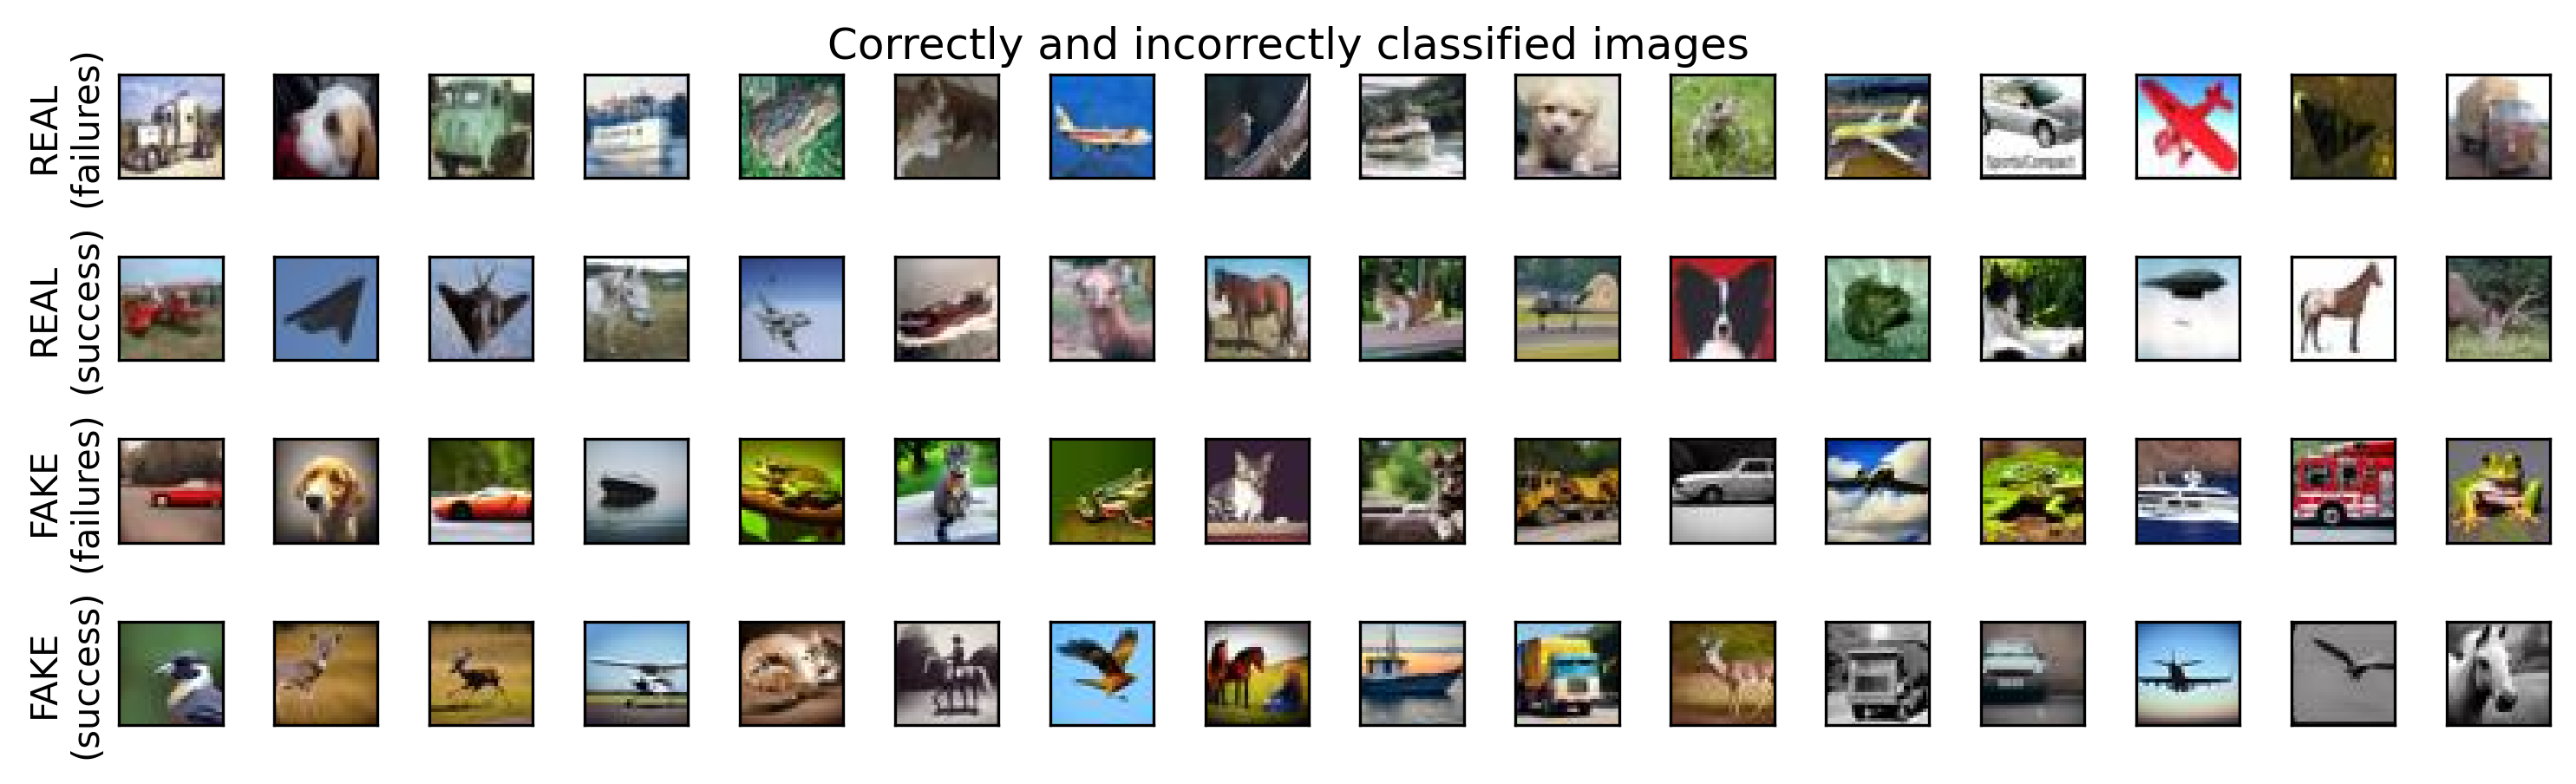

In [43]:
def plot_extreme_predictions(predicted_values, labels):

    indices_of_true_images = np.where(labels==1)
    indices_of_fake_images = np.where(labels==0)

    predicted_value_for_true_images = predicted_values[labels==1]
    predicted_value_for_fake_images = predicted_values[labels==0]

    indices_of_true_images_sorted_from_worst_to_best_prediction = np.argsort(predicted_value_for_true_images)
    indices_of_fake_images_sorted_from_worst_to_best_prediction = np.flip(np.argsort(predicted_value_for_fake_images))
    
    # Display a few images
    number_of_displayed_samples = 16
    
    fig, ax = plt.subplots(4, number_of_displayed_samples)
    fig.set_dpi(300)
    fig.set_size_inches(10, 3, forward=True)
    
    for i in range(number_of_displayed_samples):
    
        axx = ax[0, i]
        fig.sca(axx)
        index = indices_of_true_images_sorted_from_worst_to_best_prediction[i]
        plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
        plt.ylabel('REAL\n(failures)') if i==0 else None
    
        axx = ax[1, i]
        fig.sca(axx)
        index = indices_of_true_images_sorted_from_worst_to_best_prediction[9999-i]        
        plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
        plt.ylabel('REAL\n(success)') if i==0 else None
    
        axx = ax[2, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[i]        
        plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
        plt.ylabel('FAKE\n(failures)') if i==0 else None
    
        axx = ax[3, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[9999-i]             
        plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
        plt.ylabel('FAKE\n(success)') if i==0 else None
    
    [axx.set_xticks([]) for axx in ax.ravel()]
    [axx.set_yticks([]) for axx in ax.ravel()]
    plt.tight_layout()    
    plt.suptitle('Correctly and incorrectly classified images')
    plt.show()

# Model 1

In [21]:
# Design the model
model = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal', seed=random_seed),
    layers.Resizing(image_height, image_width),
    layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='silu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,313 (2.00 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=1)

Epoch 1/50


I0000 00:00:1725481818.991300  151701 service.cc:146] XLA service 0x7ebfa0004380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725481818.991319  151701 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-09-04 22:30:19.020814: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 22:30:19.139116: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 98/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6540 - loss: 0.6191 - precision: 0.6695 - recall: 0.6027

I0000 00:00:1725481820.281509  151701 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7302 - loss: 0.5166 - precision: 0.7419 - recall: 0.6985 - val_accuracy: 0.8414 - val_loss: 0.3590 - val_precision: 0.8376 - val_recall: 0.8454
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8543 - loss: 0.3411 - precision: 0.8477 - recall: 0.8615 - val_accuracy: 0.8748 - val_loss: 0.2977 - val_precision: 0.8618 - val_recall: 0.8914
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8931 - loss: 0.2598 - precision: 0.8862 - recall: 0.9001 - val_accuracy: 0.8920 - val_loss: 0.2599 - val_precision: 0.8845 - val_recall: 0.9007
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9133 - loss: 0.2175 - precision: 0.9067 - recall: 0.9198 - val_accuracy: 0.8945 - val_loss: 0.2625 - val_precision: 0.9123 - val_recall: 0.8719
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9232 - loss: 0.1940 - precision: 0.9193 - recall: 0.9269 - val_accuracy: 0.8929 - val_loss: 0.2661 - val

In [27]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9012 - loss: 0.6687 - precision: 0.9071 - recall: 0.8908
Dataset: Validation
Loss: 0.6985
Accuracy: 0.8999
Precision: 0.9083
Recall: 0.8885
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9131 - loss: 0.5703 - precision: 0.9212 - recall: 0.9023
Dataset: Test
Loss: 0.5995
Accuracy: 0.9098
Precision: 0.9183
Recall: 0.8996


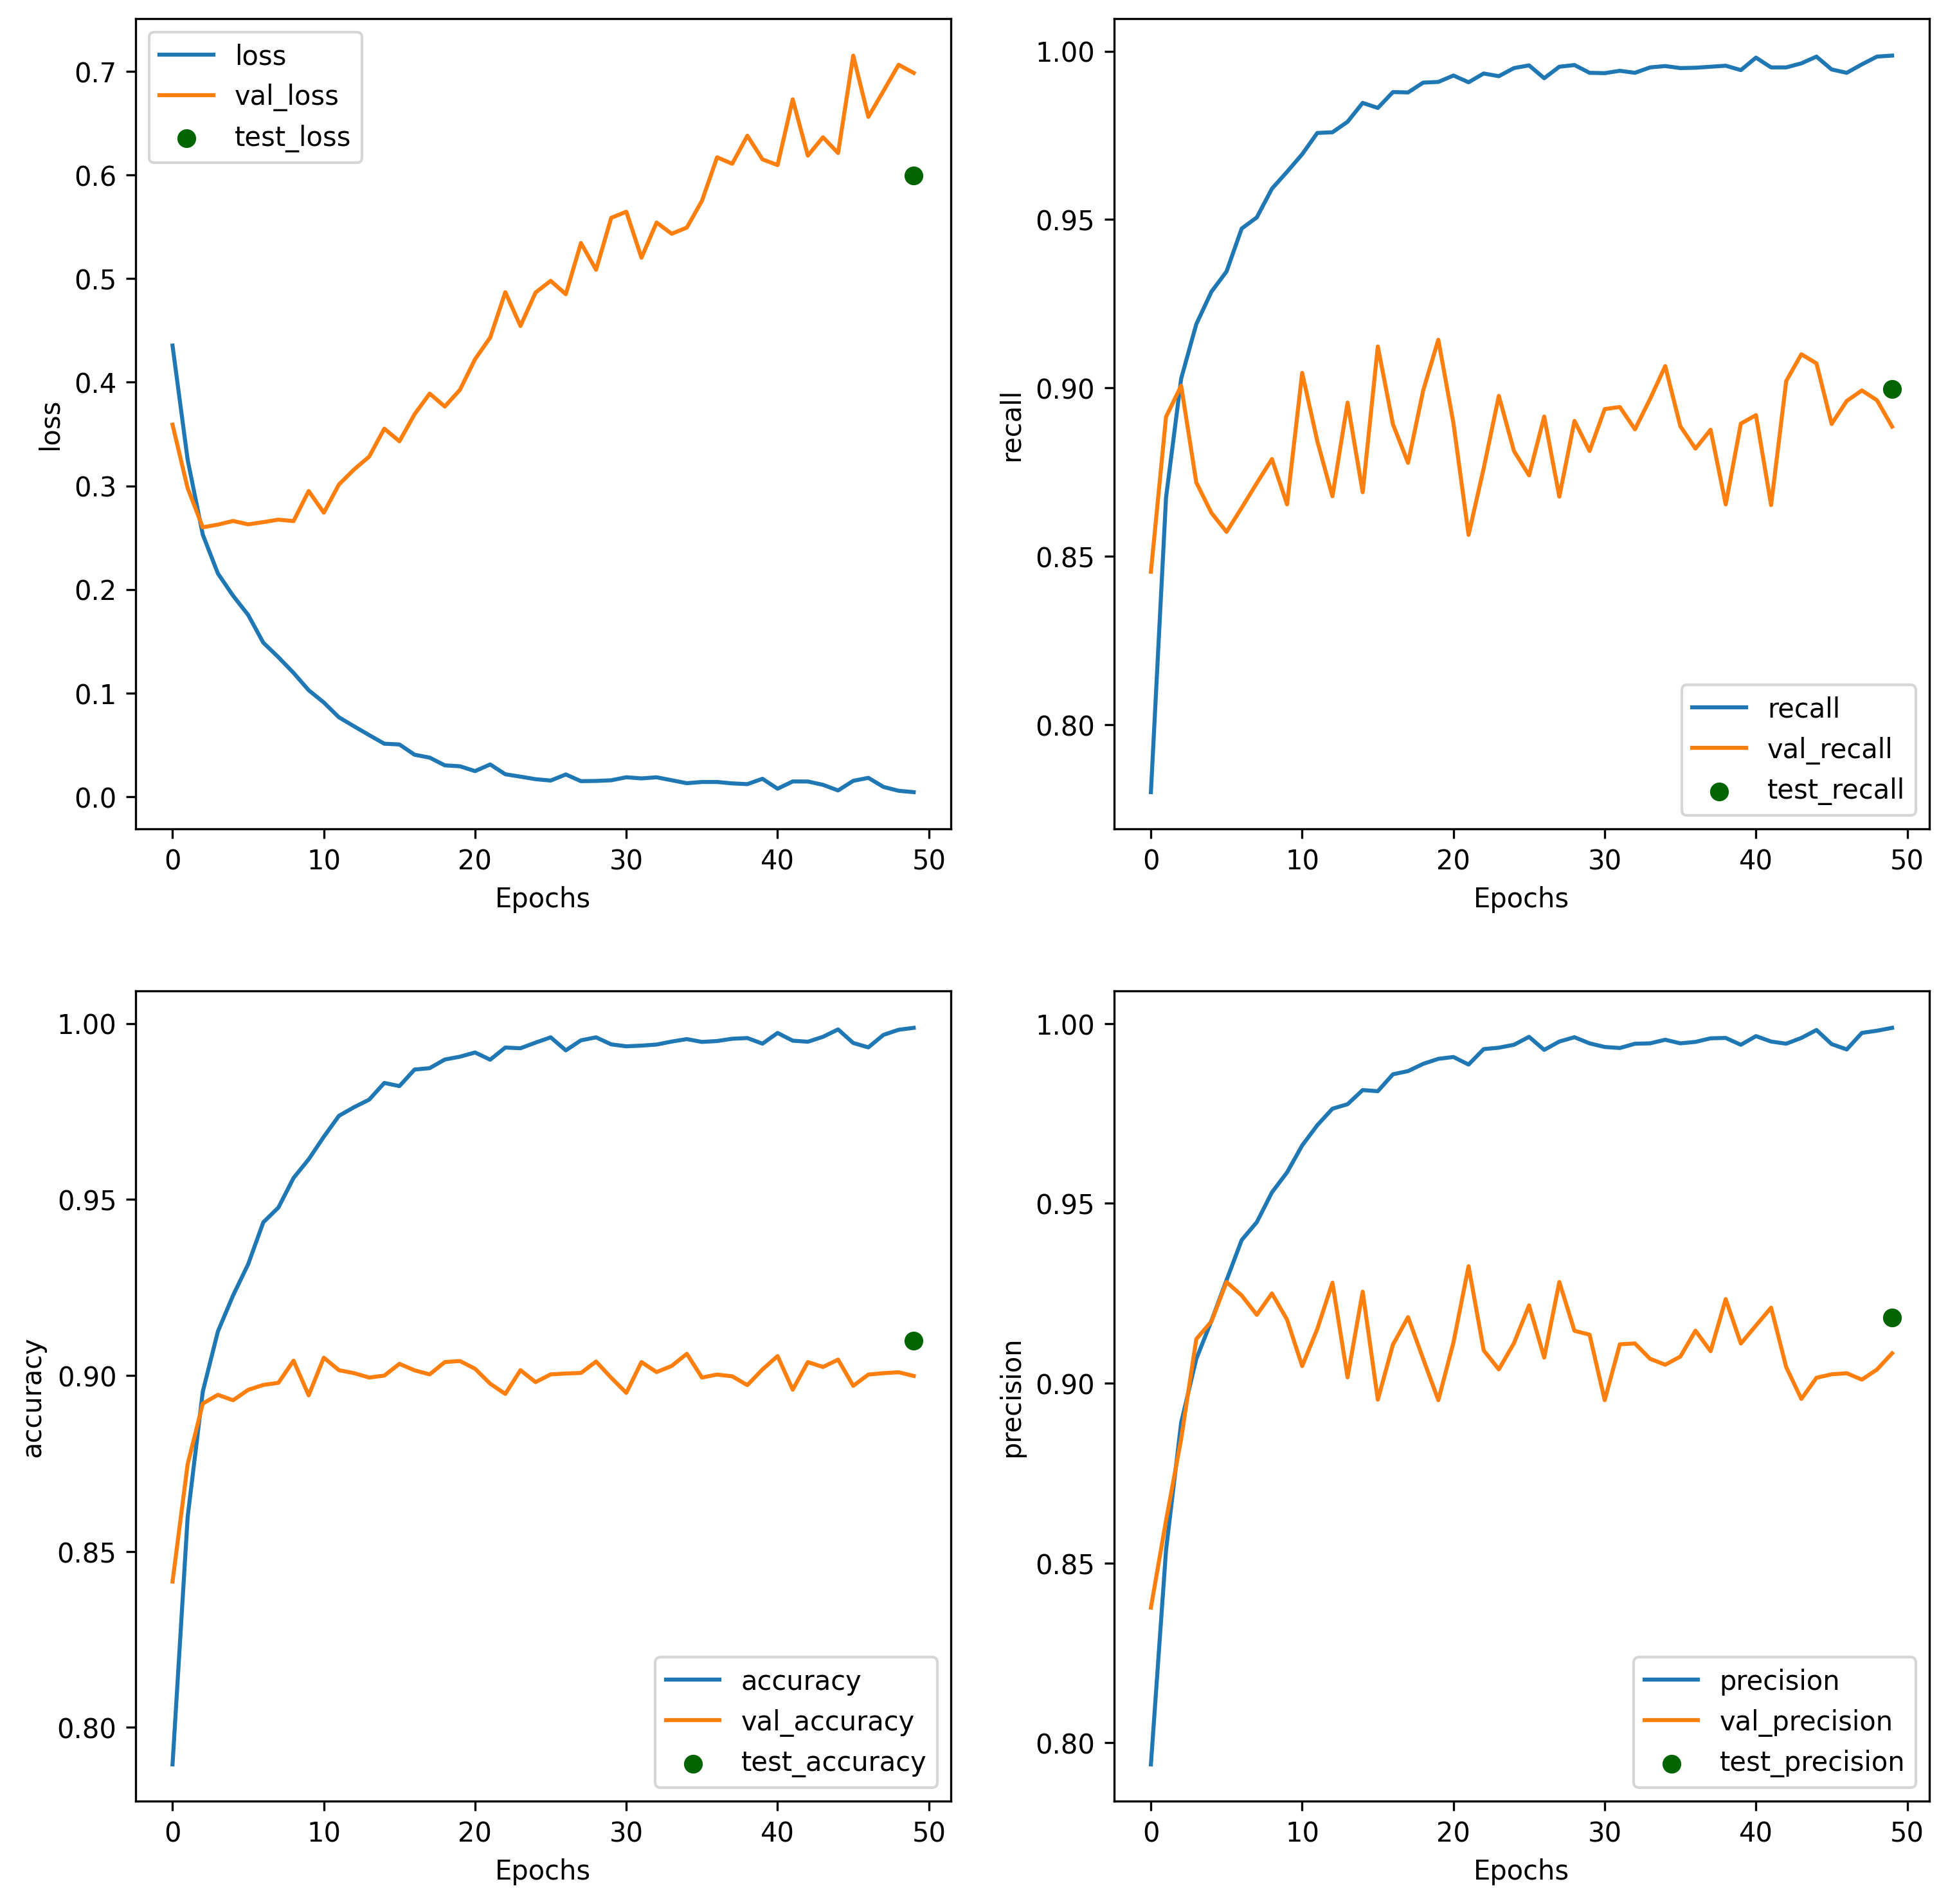

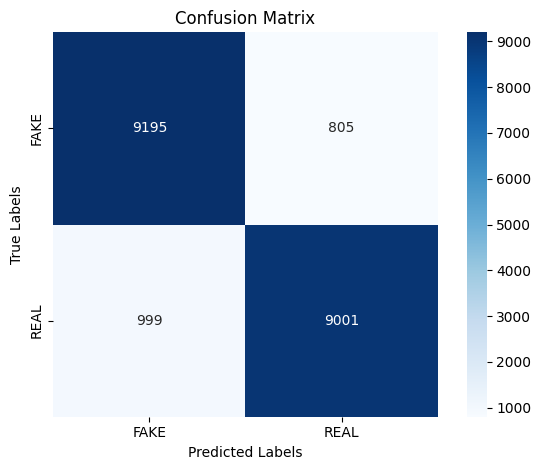

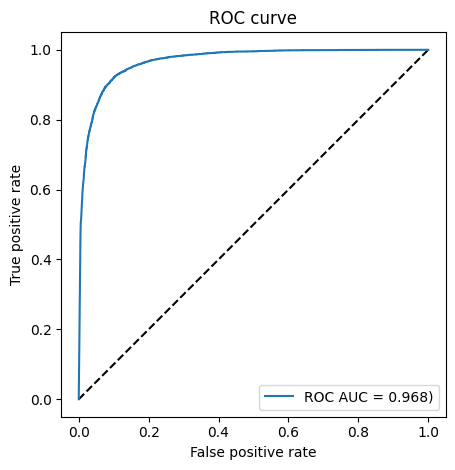

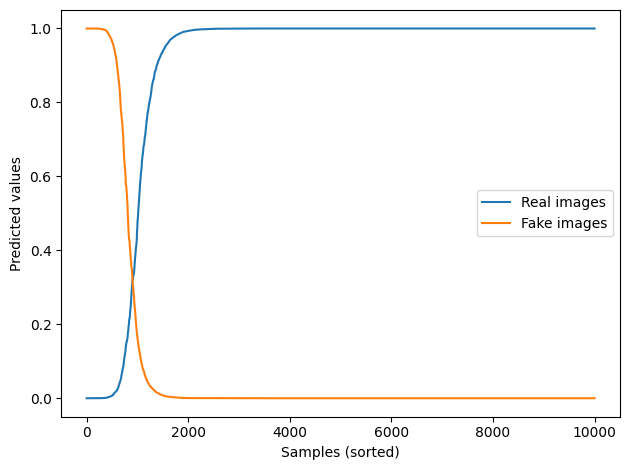

In [28]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_roc_curve(labels, predicted_values)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 2

In [44]:
# Design the model
model = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal', seed=random_seed),
    layers.Resizing(image_height, image_width),
    layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(128, activation='silu'),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,409 (2.10 MB)

 Trainable params: 549,409 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=1)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7149 - loss: 0.5282 - precision: 0.7266 - recall: 0.6581 - val_accuracy: 0.8827 - val_loss: 0.2872 - val_precision: 0.8840 - val_recall: 0.8797
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8883 - loss: 0.2798 - precision: 0.8880 - recall: 0.8874 - val_accuracy: 0.8977 - val_loss: 0.2497 - val_precision: 0.8656 - val_recall: 0.9405
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9078 - loss: 0.2339 - precision: 0.9054 - recall: 0.9089 - val_accuracy: 0.9131 - val_loss: 0.2176 - val_precision: 0.8910 - val_recall: 0.9404
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9125 - loss: 0.2157 - precision: 0.9127 - recall: 0.9114 - val_accuracy: 0.9198 - val_loss: 0.2031 - val_precision: 0.9464 - val_recall: 0.8893
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9197 - loss: 0.2043 - precision: 0.9220 - recall: 0.9154 - val_accuracy: 0.9129 - val_loss: 

In [46]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9352 - loss: 0.3227 - precision: 0.9256 - recall: 0.9444
Dataset: Validation
Loss: 0.3307
Accuracy: 0.9368
Precision: 0.9309
Recall: 0.9431
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9369 - loss: 0.3075 - precision: 0.9299 - recall: 0.9436
Dataset: Test
Loss: 0.3184
Accuracy: 0.9354
Precision: 0.9291
Recall: 0.9427


W0000 00:00:1725484627.800461  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.801289  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.802079  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.802882  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.803996  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.804751  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.805510  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.806289  151520 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725484627.807155  151520 gp

In [ ]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_roc_curve(labels, predicted_values)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Constructive criticisms about the current analysis

# Summary of main findings and takeaways to prepare next steps